# Introduction to HDF5 in Python

*18/12/2017 - Giacomo Debidda @PyData Munich*

In [1]:
import os
import numpy as np
import pandas as pd
import h5py
import tables as tb
import datashader as ds
import datashader.transfer_functions as tf

In [2]:
np.set_printoptions(precision=2, suppress=True)

In [3]:
data_dir = os.path.join(os.getcwd(), 'data')
print(data_dir)

/home/jack/Repos/hdf5-pydata-munich/data


### HDF5: a filesystem in a file

HDF5 is a data model, library, and file format for storing and managing big and complex data.

An HDF5 file can be thought of as a container (or group) that holds a variety of heterogeneous data objects (or datasets). The datasets can be almost anything: images, tables, graphs, or even documents, such as PDF or Excel.

- Datasets (i.e. files in a filesystem)
- Groups (i.e. directories in a filesystem)
- Attributes (i.e. metadata of file/directory)

![HDF5 structure](img/hdf5_structure.jpg)

Working with groups and group members is similar to working with directories and files in UNIX.

**/** root group (every HDF5 file has a root group)

**/foo** member of the root group called foo

**/foo/bar** member of the group foo called bar

### HDF5 in the Python data stack

![h5py - PyTables refactor](img/h5py-pytables-refactor.png)

In [4]:
%%time
df = pd.read_hdf(path_or_buf='data/NYC-yellow-taxis.h5', key='/yellow_2015_01')

CPU times: user 9.63 s, sys: 3.06 s, total: 12.7 s
Wall time: 13.5 s


In [5]:
df.shape

(12748986, 17)

In [6]:
# New York City x/y range (meters)
x_range = (-8242000, -8210000)
y_range = (4965000, 4990000)

In [7]:
%%time
cvs = ds.Canvas(plot_width=600, plot_height=600, x_range=x_range, y_range=y_range)
agg = cvs.points(df, 'pickup_x', 'pickup_y',  ds.count('passenger_count'))
img = tf.shade(agg, cmap=['#deebf7','#9ecae1','#3182bd'], how='log')

CPU times: user 704 ms, sys: 64 ms, total: 768 ms
Wall time: 1.17 s


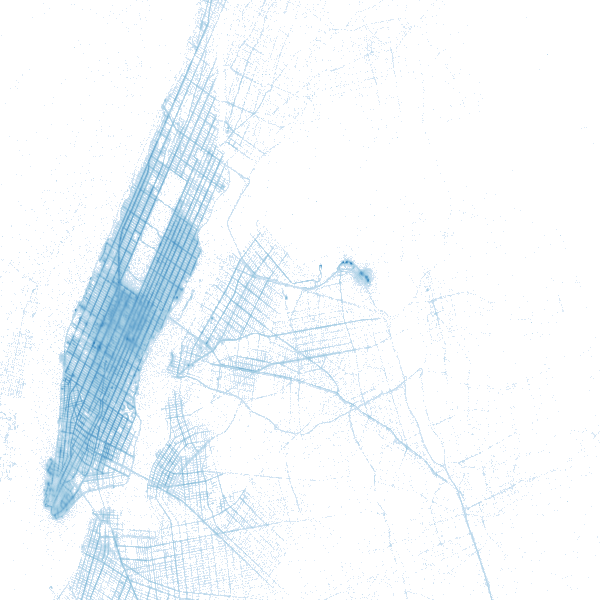

In [8]:
img

---

# h5py

- Thin, pythonic wrapper around the HDF5 C API
- Written in Cython
- Tries to expose the entire HDF5 C API

![Python and HDF5 book](img/h5py-book.gif)

### Datasets

In [9]:
with h5py.File(name='data/my_h5py_file.h5', mode='w') as f:
    f.create_dataset(name='my_dataset', data=[1.0, 2.7, 3.7, 4.5])
    f.create_dataset(name='another_dataset', data=[1, 2, 3, 4])
    f.create_dataset(name='yet_another_dataset', data=[1, 2, 3, 4], dtype=np.float32)

In [11]:
with h5py.File(name='data/my_h5py_file.h5', mode='r') as f:
    # the array is just a proxy object
    print(f['my_dataset'])
    # the actual data can be accessed with these 2 syntaxes
    print(f['my_dataset'][:])
    print(f['my_dataset'][...])

<HDF5 dataset "my_dataset": shape (4,), type "<f8">
[ 1.   2.7  3.7  4.5]
[ 1.   2.7  3.7  4.5]


### Preallocation on disk

In [12]:
with h5py.File(name='data/my_h5py_file.h5', mode='w') as f:
    dataset = f.create_dataset(name='my_dataset', shape=(8, 1))
    dataset[0] = 5.2
    dataset[1] = 7

In [13]:
with h5py.File(name='data/my_h5py_file.h5', mode='a') as f:
    dataset = f['my_dataset']
    dataset[2] = 3.9
    dataset[3] = 8.3

### Pick the correct HDF5 datatype

In [14]:
arr = np.array([0, 1, 254, 255, 256, -1, -2], dtype='uint8')
print(arr)

[  0   1 254 255   0 255 254]


In [15]:
with h5py.File(name='data/my_h5py_file.h5', mode='w') as f:
    f.create_dataset(name='my_dataset', shape=(7,), dtype=h5py.h5t.STD_U8BE)
    f['my_dataset'][0:8] = [0, 1, 254, 255, 123456, -1, -2]
    print(f["my_dataset"][:])

[  0   1 254 255 255   0   0]


### Groups

In [16]:
with h5py.File(name='data/my_h5py_file.h5', mode='w') as f:
    f.create_group(name='group1')
    group2 = f.create_group(name='group2')
    group2.create_group(name='group3')

In [17]:
with h5py.File(name='data/my_h5py_file.h5', mode='r') as f:
    group3 = f['group2/group3']
    print(group3.parent)

<HDF5 group "/group2" (1 members)>


### Attributes

In [18]:
with h5py.File(name='data/my_h5py_file.h5', mode='w') as f:
    dataset = f.create_dataset(name='my_dataset', data=[1, 2, 3, 4])
    dataset.attrs['Unit'] = 4
    gr = f.create_group(name='my_group')
    gr.attrs['Created'] = '18/12/2017'
    gr.attrs.create(name='Versions', data=np.array([123, 456])) 

### Traverse a HDF5 file with h5py

In [19]:
with h5py.File(name='data/my_h5py_file.h5', mode='r') as f:
    f.visit(print)

my_dataset
my_group


### HDF5 Command Line Tools

[Here](https://support.hdfgroup.org/products/hdf5_tools/#h5dist) you can find the command line tools developed by the HDF Group. You don't need h5py or PyTables to use them.

If you are on Ubuntu, you can install them with `sudo apt install hdf5-tools`

In [20]:
# -r stands for 'recursive'
!h5ls -r 'data/my_h5py_file.h5'

/                        Group
/my_dataset              Dataset {4}
/my_group                Group


In [21]:
!h5dump 'data/my_h5py_file.h5'

HDF5 "data/my_h5py_file.h5" {
GROUP "/" {
   DATASET "my_dataset" {
      DATATYPE  H5T_STD_I64LE
      DATASPACE  SIMPLE { ( 4 ) / ( 4 ) }
      DATA {
      (0): 1, 2, 3, 4
      }
      ATTRIBUTE "Unit" {
         DATATYPE  H5T_STD_I64LE
         DATASPACE  SCALAR
         DATA {
         (0): 4
         }
      }
   }
   GROUP "my_group" {
      ATTRIBUTE "Created" {
         DATATYPE  H5T_STRING {
            STRSIZE H5T_VARIABLE;
            STRPAD H5T_STR_NULLTERM;
            CSET H5T_CSET_UTF8;
            CTYPE H5T_C_S1;
         }
         DATASPACE  SCALAR
         DATA {
         (0): "18/12/2017"
         }
      }
      ATTRIBUTE "Versions" {
         DATATYPE  H5T_STD_I64LE
         DATASPACE  SIMPLE { ( 2 ) / ( 2 ) }
         DATA {
         (0): 123, 456
         }
      }
   }
}
}


---

# PyTables

- Higher abstraction over HDF5 (it's more "battery included")
- Searches are faster than in h5py
- Does not depend on h5py (at the moment)

![PyTables logo](img/pytables-logo.png)

### Array


In [23]:
with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
    f.create_array(where='/', 
                   name='my_array',
                   title='My PyTables Array',
                   obj=[1, 2, 3, 4])

PyTables has a feature called "Natural Naming": nodes (i.e. datasets and groups in the HDF5 file) can be accessed with the dot notation.

In [24]:
with tb.open_file(filename='data/my_pytables_file.h5', mode='r') as f:
    print(f.root.my_array)

/my_array (Array(4,)) 'My PyTables Array'


### Groups

In [25]:
with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
    f.create_group(where='/', name='my_group')

### Attributes

In [26]:
with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
    f.create_array(where=f.root, name='my_array', obj=[1, 2, 3, 4], title='My PyTables Array')
    f.set_node_attr(where='/my_array', attrname='SomeAttribute', attrvalue='SomeValue')
    f.create_group(where='/', name='my_group')
    f.set_node_attr(where='/my_group', attrname='SomeOtherAttribute', attrvalue=123)

### HDF5 datasets have many abstractions in PyTables

Homogenous dataset:

- **Array**
- **CArray**
- **EArray**
- **VLArray**

Heterogenous dataset:

- **Table**

In [27]:
num_rows = 1000000  # 1 million
gaussian = np.random.normal(loc=0, scale=1, size=num_rows).astype('float32')
uniform = np.random.uniform(low=100, high=150, size=num_rows).astype('uint8')
num_columns = 5
matrix = np.random.random((num_rows, num_columns)).astype('float32')

### Array (again!)

[Docs](http://www.pytables.org/usersguide/libref/homogenous_storage.html#the-array-class)

- Fastest I/O speed
- Must fit in memory
- Not compressible
- Not enlargeable

In [28]:
%%time
with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
    f.create_array(where='/', name='gaussian', obj=gaussian)
    f.create_array(where='/', name='uniform', obj=uniform)
    f.create_array(where='/', name='matrix', obj=matrix)

CPU times: user 8 ms, sys: 104 ms, total: 112 ms
Wall time: 114 ms


### CArray

[Docs](http://www.pytables.org/usersguide/libref/homogenous_storage.html#carrayclassdescr)

- Compressible
- Not enlargeable

In [29]:
filters = tb.Filters(complevel=5, complib='zlib')

Tips on how to use compression (from the PyTables docs)

- A mid-level (5) compression is sufficient. No need to go all the way up (9)
- Use zlib if you must guarantee complete portability
- Use blosc all other times (it is optimized for HDF5)

In [30]:
%%time
with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
#     f.create_carray(where='/', name='gaussian', obj=gaussian)
#     f.create_carray(where='/', name='uniform', obj=uniform)
#     f.create_carray(where='/', name='matrix', obj=matrix)
    f.create_carray(where='/', name='gaussian', obj=gaussian, filters=filters)
    f.create_carray(where='/', name='uniform', obj=uniform, filters=filters)
    f.create_carray(where='/', name='matrix', obj=matrix, filters=filters)

CPU times: user 996 ms, sys: 108 ms, total: 1.1 s
Wall time: 1.25 s


### EArray

[Docs](http://www.pytables.org/usersguide/libref/homogenous_storage.html#earrayclassdescr)

- Enlargeable on **one** dimension (append)
- Compressible

In [31]:
# One (and only one) of the shape dimensions *must* be 0.
# The dimension being 0 means that the resulting EArray object can be extended along it.
# Multiple enlargeable dimensions are not supported right now.
shape = (0, num_columns)

with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
    # you can create an EArray and fill it later, but you need to specify atom and shape
    f.create_earray(where='/', name='my_earray', atom=tb.Float32Atom(), shape=shape, filters=filters)

In [32]:
with tb.open_file(filename='data/my_pytables_file.h5', mode='a') as f:
    earray = f.root.my_earray
    earray.append(sequence=matrix[0:1, :])

In [33]:
with tb.open_file(filename='data/my_pytables_file.h5', mode='a') as f:
    earray = f.root.my_earray
    earray.append(sequence=matrix[1:5, :])

### Table

[Docs](http://www.pytables.org/usersguide/libref/structured_storage.html?highlight=table#tableclassdescr)

- Data can be heterogeneous (i.e. different shapes and different dtypes)
- The structure of a table is declared by its description
- multi-column searches

In order to emulate in Python records mapped to HDF5 C structs PyTables implements a special class so as to easily define all its fields and other properties. It's called `IsDescription`.

A *description* defines the table structure (basically, the *schema* of your table).

In [34]:
class Particle(tb.IsDescription):
    identity = tb.StringCol(itemsize=22, dflt=' ', pos=0)  # character String
    idnumber = tb.Int16Col(dflt=1, pos=1)  # short integer

In [35]:
print(Particle.columns)

{'idnumber': Int16Col(shape=(), dflt=1, pos=1), 'identity': StringCol(itemsize=22, shape=(), dflt=b' ', pos=0)}


In [36]:
with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
    table = f.create_table(where='/', name='my_table', description=Particle)

    for i in range(100):
        table.row['identity'] = 'I am {identity}'.format(identity=i)
        table.row['idnumber'] = i
        table.row.append()
    table.flush()  # Flush the table buffers to release memory and make sure are written to disk

In [37]:
with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
    table = f.create_table(where='/', name='my_table', description=Particle)
    
    for i in range(100):
        table.append([('I am {identity}'.format(identity=i), i)])
        
    table.flush()  # Flush the table buffers to release memory and make sure are written to disk

### Traverse a HDF5 file with PyTables

In [38]:
with tb.open_file(filename='data/my_pytables_file.h5', mode='r') as f:
    for node in f.walk_nodes('/', classname='Table'):
        print('{}'.format(node._v_pathname))

/my_table


### Expressions with NumExpr

In [40]:
x = np.random.uniform(low=1, high=5, size=num_rows).astype('float32')

In [41]:
%%time
with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
    carray = f.create_carray(where='/', name='carray_without_numexpr', atom=tb.Float32Atom(), shape=x.shape)
    carray[:] = x**3 + 0.5*x**2 - x

CPU times: user 120 ms, sys: 36 ms, total: 156 ms
Wall time: 203 ms


In [42]:
%%time
with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
    carray = f.create_carray(where='/', name='carray_with_numexpr', atom=tb.Float32Atom(), shape=x.shape)
    ex = tb.Expr('x**3 + 0.5*x**2 - x')
    ex.set_output(carray) # output will got to the CArray on disk
    ex.eval()

CPU times: user 28 ms, sys: 28 ms, total: 56 ms
Wall time: 203 ms


# NYC Yellow Taxi Dataset (2015)

On my laptop (Thinkpad X220 i5 10GB RAM) it took roughly:

- **40 minutes** to read/store a **single CSV**

- **8 hours** to read/store an entire **year**

![still waiting](img/still-waiting-meme.jpg)

In [43]:
!h5ls 'data/NYC-yellow-taxis.h5'

yellow_2015_01           Dataset {12748986/Inf}
yellow_2015_02           Dataset {12450521/Inf}
yellow_2015_03           Dataset {13351609/Inf}
yellow_2015_04           Dataset {13071789/Inf}
yellow_2015_05           Dataset {13158262/Inf}
yellow_2015_06           Dataset {12324935/Inf}
yellow_2015_07           Dataset {11562783/Inf}
yellow_2015_08           Dataset {11130304/Inf}
yellow_2015_09           Dataset {11225063/Inf}
yellow_2015_10           Dataset {12315488/Inf}
yellow_2015_11           Dataset {11312676/Inf}
yellow_2015_12           Dataset {11460573/Inf}


PyTables is shipped with some useful command line utilities. These CLI utils are in `tables/utils`.

You can use them if you are working in a python environment where you installed PyTables (these CLI utils cause your python interpreter to execute a python script in `tables/scripts`).

In [44]:
!pttree --use-si-units --sort-by 'size' 'data/NYC-yellow-taxis.h5'


------------------------------------------------------------

/ (RootGroup)
+--yellow_2015_03 (Table)
|     mem=894.6MB, disk=433.3MB [ 9.3%]
+--yellow_2015_05 (Table)
|     mem=881.6MB, disk=425.0MB [ 9.1%]
+--yellow_2015_04 (Table)
|     mem=875.8MB, disk=423.1MB [ 9.0%]
+--yellow_2015_01 (Table)
|     mem=854.2MB, disk=409.4MB [ 8.7%]
+--yellow_2015_02 (Table)
|     mem=834.2MB, disk=402.7MB [ 8.6%]
+--yellow_2015_06 (Table)
|     mem=825.8MB, disk=397.9MB [ 8.5%]
+--yellow_2015_10 (Table)
|     mem=825.1MB, disk=390.4MB [ 8.3%]
+--yellow_2015_07 (Table)
|     mem=774.7MB, disk=366.3MB [ 7.8%]
+--yellow_2015_12 (Table)
|     mem=767.9MB, disk=363.5MB [ 7.8%]
+--yellow_2015_11 (Table)
|     mem=757.9MB, disk=359.0MB [ 7.7%]
+--yellow_2015_09 (Table)
|     mem=752.1MB, disk=356.2MB [ 7.6%]
`--yellow_2015_08 (Table)
      mem=745.7MB, disk=353.3MB [ 7.5%]

------------------------------------------------------------
Total branch leaves:    12
Total branch size:      9.8GB in memory, 4

### Searches

`tables.Table.read` reads the **entire table** (it must fit into memory) and query it with NumPy.

In [45]:
%%time
with tb.open_file(filename='data/NYC-yellow-taxis-100k.h5', mode='r') as f:
    table = f.get_node(where='/yellow_2015_01')
    rows = table.read()
    amounts = [row['total_amount'] for row in rows if row['passenger_count'] == 1]
    
print(len(amounts))

70857
CPU times: user 856 ms, sys: 36 ms, total: 892 ms
Wall time: 1.13 s


`tables.Table.iterrows` returns an **iterator** that iterates over all rows (so no need to load the entire table into memory).

In [46]:
%%time
with tb.open_file(filename='data/NYC-yellow-taxis-100k.h5', mode='r') as f:
    table = f.get_node(where='/yellow_2015_01')
    rows = table.iterrows()
    amounts = [row['total_amount'] for row in rows if row['passenger_count'] == 1]
    
print(len(amounts))

70857
CPU times: user 184 ms, sys: 0 ns, total: 184 ms
Wall time: 343 ms


`tables.Table.read_where` uses **NumExpr** to make a **in-kernel** query.

It gets all the rows which fulfill the given condition and packs them in a single container, like `tables.Table.read`.

In [47]:
%%time
with tb.open_file(filename='data/NYC-yellow-taxis-100k.h5', mode='r') as f:
    table = f.get_node(where='/yellow_2015_01')
    rows = table.read_where('passenger_count == 1')
    amounts = [x['total_amount'] for x in rows]
    
print(len(amounts))

70857
CPU times: user 544 ms, sys: 8 ms, total: 552 ms
Wall time: 789 ms


`tables.Table.where` uses **NumExpr** to make a **in-kernel** query.

It iterates over the rows in a table which fulfill the given condition, like `tables.Table.iterrows`.

In [48]:
%%time
with tb.open_file(filename='data/NYC-yellow-taxis-100k.h5', mode='r') as f:
    table = f.get_node(where='/yellow_2015_01')
    rows = table.where('passenger_count == 1')
    amounts = [x['total_amount'] for x in rows]
    
print(len(amounts))

70857
CPU times: user 116 ms, sys: 4 ms, total: 120 ms
Wall time: 121 ms


### Add Indexes to the table

Indexing affects only `table.Table.where` and `table.Table.read_where`.

In [60]:
with tb.open_file(filename='data/NYC-yellow-taxis-100k.h5', mode='a') as f:
    table = f.get_node(where='/yellow_2015_01')
    table.cols.trip_distance.create_index()
    table.cols.passenger_count.create_index()

In [61]:
!h5ls 'data/NYC-yellow-taxis-100k.h5'

_i_yellow_2015_01        Group
yellow_2015_01           Dataset {100000/Inf}
yellow_2015_02           Dataset {100000/Inf}
yellow_2015_03           Dataset {100000/Inf}
yellow_2015_04           Dataset {100000/Inf}
yellow_2015_05           Dataset {100000/Inf}
yellow_2015_06           Dataset {100000/Inf}
yellow_2015_07           Dataset {100000/Inf}
yellow_2015_08           Dataset {100000/Inf}
yellow_2015_09           Dataset {100000/Inf}
yellow_2015_10           Dataset {100000/Inf}
yellow_2015_11           Dataset {100000/Inf}
yellow_2015_12           Dataset {100000/Inf}


### Index performance

 Indexing works best when there is only a small subset of the total data set that you are querying for (see [this answer](https://stackoverflow.com/a/20789807/3036129)).
 
In regular selection mode  (`tables.Table.read` and `tables.Table.iterrows`) the condition is evaluated in Python.

In the in-kernel mode (`tables.Table.where` and `tables.Table.read_where`), the condition is passed to the PyTables kernel (hence the name), written in C, and evaluated there at full C speed (with the help of the integrated NumExpr package). The only values that are brought to the Python space are the rows that fulfilled the condition.

In [57]:
%%time
with tb.open_file(filename='data/NYC-yellow-taxis-indexed.h5', mode='r') as f:
    table = f.get_node(where='/yellow_2015_01')
    rows = table.iterrows()
    amounts = [row['total_amount'] for row in rows
               if row['passenger_count'] == 3 and row['trip_distance'] > 30]
    
print(len(amounts))

163
CPU times: user 8.01 s, sys: 168 ms, total: 8.18 s
Wall time: 8.19 s


In [58]:
%%time
condition = '(passenger_count == 3) & (trip_distance > 30)'
with tb.open_file(filename='data/NYC-yellow-taxis-indexed.h5', mode='r') as f:
    table = f.get_node(where='/yellow_2015_01')
    rows = table.where(condition)
    amounts = [x['total_amount'] for x in rows]
    
print(len(amounts))

163
CPU times: user 1.89 s, sys: 52 ms, total: 1.94 s
Wall time: 1.89 s


# Visualization

In [59]:
condition = '((1 < passenger_count) & (passenger_count < 4)) & (trip_distance > 0.5)'
# This won't work: you can't use Python's standard boolean operators in NumExpr expressions
# condition = '(1 < passenger_count < 4) & (trip_distance > 20.0)'

In [61]:
%%time
with tb.open_file(filename='data/NYC-yellow-taxis.h5', mode='r') as f:
    table = f.get_node(where='/yellow_2015_01')
    matches = [(x['pickup_x'], x['pickup_y'], x['passenger_count']) for x in table.where(condition)]

df_matches = pd.DataFrame(matches, columns=['pickup_x', 'pickup_y', 'passenger_count'])
print(df_matches.shape)

(2218407, 3)
CPU times: user 10.8 s, sys: 708 ms, total: 11.5 s
Wall time: 11.2 s


In [62]:
# New York City x/y range (meters)
x_range = (-8242000, -8210000)
y_range = (4965000, 4990000)

cvs = ds.Canvas(plot_width=600, plot_height=600, x_range=x_range, y_range=y_range)

agg1 = cvs.points(source=df, x='pickup_x', y='pickup_y', agg=ds.count('passenger_count'))
img1 = tf.shade(agg, cmap=['#deebf7','#9ecae1','#3182bd'], how='log')

agg2 = cvs.points(source=df_matches, x='pickup_x', y='pickup_y', agg=ds.count('passenger_count'))
img2 = tf.shade(agg2, cmap=['yellow', 'orange'], how='log')

img = tf.stack(img1, img2)

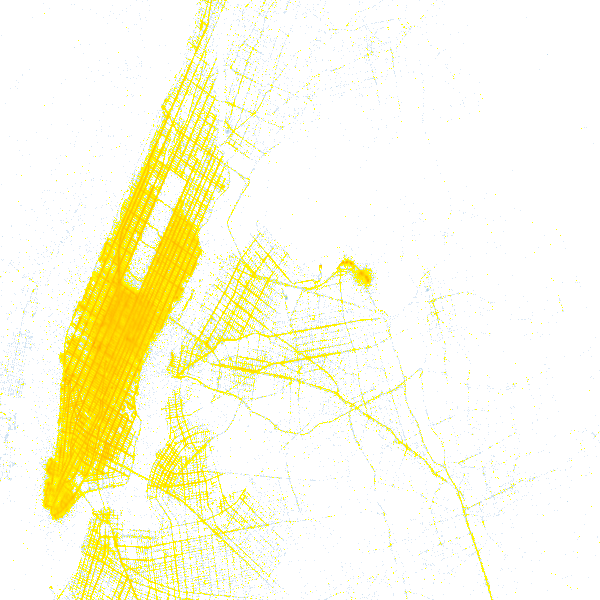

In [63]:
img

---

# Reference

- [Introduction to HDF5](https://www.youtube.com/watch?v=BAjsCldRMMc) by Quincey Koziol
- [HDF5 is Eating the World](https://www.youtube.com/watch?v=nddj5OA8LJo) by Andrew Collette
- [HDF5 take 2 - h5py & PyTables](https://www.youtube.com/watch?v=ofLFhQ9yxCw) by Tom Kooij
- [SciPy 2017 notebooks](https://github.com/tomkooij/scipy2017/tree/master/notebooks) by Tom Kooij
- [h5py documentation](http://docs.h5py.org/en/latest/)
- [PyTables documentation](http://www.pytables.org/index.html)
- [The starving CPU problem (Francesc Alted)](https://python.g-node.org/python-summerschool-2013/_media/starving_cpu/starvingcpus.pdf)